In [0]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output

class TorchSin(torch.nn.Module):
    """
    Sin activation function
    """
    def __init__(self):
        super(TorchSin, self).__init__()

    def forward(self, x):
        return torch.sin(x)

class Generator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, 
                 activation=nn.Tanh(),
                 output_tan=True):
        
        super(Generator, self).__init__()

        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
            
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if output_tan:
            self.layers.append(nn.Tanh())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, 
                 activation=nn.Tanh(), 
                 unbounded=False):
        
        super(Discriminator, self).__init__()
        
        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
        
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if not unbounded:
            # unbounded for WGAN (no sigmoid)
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

def realtime_vis(g_loss, d_loss, t, preds, analytic_fn, dx_dt, d2x_dt2, savefig=False, fname=None):
    fig, ax = plt.subplots(1,3,figsize=(20,6))
    steps = len(g_loss)
    epochs = np.arange(steps)

    ax[0].plot(epochs, [d[0] for d in d_loss], label='d_loss', color='orange')
    ax[0].plot(epochs, [d[1] for d in d_loss], label='d_loss_fake', color='g')
    ax[0].plot(epochs, [d[2] for d in d_loss], label='d_loss_real', color='b')
    ax[0].plot(epochs, g_loss, label='g_loss', color='r')
    ax[0].legend()
    ax[0].set_title('Losses')

    ax[1].plot(t, analytic_fn(t), label='true')
    ax[1].plot(t, preds, '--', label='pred')
    ax[1].legend()
    ax[1].set_title('X Pred')

    ax[2].plot(t, dx_dt, label='dx_dt')
    ax[2].plot(t, d2x_dt2, label='d2x_dt2')
    ax[2].plot(t, preds, '--', label='x')
    ax[2].legend()
    ax[2].set_title('Derivatives')

    if not savefig:
        plt.show()
    else:
        plt.savefig(fname)

def diff(x, t):
    dx_dt, = autograd.grad(x, t,
                           grad_outputs=x.data.new(x.shape).fill_(1),
                           create_graph=True)
    return dx_dt

def train_GAN_SHO(
                num_epochs,
                activation=nn.Tanh(),
                g_hidden_units=10,
                d_hidden_units=10,
                g_hidden_layers=2,
                d_hidden_layers=2,
                d_lr=0.001,
                g_lr=0.001,
                d_betas=(0.9, 0.999),
                g_betas=(0.9, 0.999),
                G_iters=1,
                D_iters=1,
    
                t_low=0,
                t_high=10,
                x0=0,
                dx_dt0=.5,
                n=100,
                m=1.,
                k=1.,
                real_label=1,
                fake_label=0,
                
                logging=True,
                realtime_plot=False,
                
                soft_labels=False,
                real_data=False,
                loss_diff=.1,
                max_while=20,
                
                wgan=False,
                clip=.1,
                gradient_penalty=False,
                gp_hyper=0.1,
                
                systemOfODE=False,
                conditionalGAN=False,
                savefig=False,
                fname=None,
                device=None,
                check_every=100):

    """
    function to perform training of generator and discriminator for num_epochs
    equation: simple harmonic oscillator (SHO)
    gan hacks:
        - wasserstein + clipping / wasserstein GP
        - label smoothing
        - while loop iters
    """
    if savefig and realtime_plot:
        raise Exception('savefig and realtime_plot both True. Assuming you dont want that.')

    if wgan:
        fake_label = -1

    # initialize nets
#     G = Generator(in_dim=1, out_dim=1,
#                   n_hidden_units=g_hidden_units,
#                   n_hidden_layers=g_hidden_layers,
#                   activation=activation, # twice diff'able activation
#                   output_tan=True) # true output range should be (-1,1) if True
    G = LSTM(input_dim=1, hidden_dim=20, batch_size=1, output_dim=1,
                    num_layers=2, output_tan=True)

    # in_dim = 2 for conditional GAN
    d_in_dim = 1 if not conditionalGAN else 2
    D = Discriminator(in_dim=d_in_dim, out_dim=1,
                      n_hidden_units=d_hidden_units,
                      n_hidden_layers=d_hidden_layers,
                      activation=activation,
                      unbounded=wgan) # true for WGAN

    # grid
    t_torch = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    t_np = np.linspace(t_low, t_high, n).reshape(-1,1)

    delta_t = t_torch[1]-t_torch[0]
    def get_batch():
        """ perturb grid """
        return t_torch + delta_t * torch.randn_like(t_torch) / 3

    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)

    # optimization
    if wgan:
        criterion = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    else:
        criterion = nn.BCELoss()

    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=g_betas)
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=d_betas)

    # logging
    D_losses = []
    G_losses = []

    analytic_oscillator = lambda t: x0*torch.cos(t) + dx_dt0*torch.sin(t)
    analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)

    def produce_SHO_preds(G, t):
#         transpose for vector input
#         t = torch.t(t)

        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)
        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2

    def produce_SHO_preds_system(G, t):
        x_pred = G(t)
        
        # x condition
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_pred
        
        # dx_dt (directly from NN output, x_pred)
        dx_dt = diff(x_pred, t)
        
        # u condition guarantees that dx_dt = u (first equation in system)
        u_adj = torch.exp(-t) * dx_dt0 + 2 * (1 - torch.exp(-t)) * torch.exp(-t) * x_pred + (1 - torch.exp(-t)) * dx_dt
        
        # compute du_dt = d2x_dt2
        du_dt = diff(u_adj, t)

        return x_adj, u_adj, du_dt

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========

        for p in D.parameters():
            p.requires_grad = False # turn off computation for D when updating G

        t = get_batch()
        if real_data:
            real = analytic_oscillator(t)
            
#         ## DEBUGGING
#         if (epoch//100) % 2 == 0:
#             print('running g')
#             G_iters=1
#             D_iters=0
#         else:
#             print('running d')
#             G_iters=0
#             D_iters=1
            

        for i in range(G_iters):

            if systemOfODE:
                x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                d2x_dt2 = du_dt
                
            else:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t)

            if real_data:
                fake = x_adj
            else:
                # ADD RESHAPE FOR VECTOR INPUT
                real = x_adj #.reshape(-1)
                fake = -(m/k)*d2x_dt2 #.reshape(-1)
                
            # FOR CONDITIONAL GAN: 
            # input t with real/fake (to discriminator)
            if conditionalGAN:
              real = torch.cat((real, t), 1)
              fake = torch.cat((fake, t), 1)
            
            # VECTOR BASED DEBUG
#             print('real shape: {}'.format(real.shape))
#             print('fake shape: {}'.format(fake.shape))

            if wgan:
                # WGAN loss from paper
                g_loss = torch.mean(-D(fake))
                
            else:
                # generator loss
                g_loss = criterion(D(fake), real_label_vec)

            optiG.zero_grad() # zero grad before backprop
            g_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                g_grad_norm = nn.utils.clip_grad_norm_(G.parameters(), clip)
            optiG.step()

        ## =========
        ##  TRAIN D
        ## =========

        for p in D.parameters():
            # TODO: should we turn off G?
            p.requires_grad = True # turn on computation for D

        for i in range(D_iters):

            if soft_labels:
                real_label_vec_ = real_label_vec + (-.2 + .4 * torch.rand_like(real_label_vec))
                fake_label_vec_ = fake_label_vec + (-.2 + .4 * torch.rand_like(fake_label_vec))
            else:
                real_label_vec_ = real_label_vec
                fake_label_vec_ = fake_label_vec

            ## WGAN - GP penalty
            norm_penalty = torch.zeros(1)
            
            if wgan and gradient_penalty:
                total_norm = torch.zeros(1)
                
                # sample epsilon for each sample in the batch
                eps_mix = torch.rand(real.shape[0]) 
                x_mix = torch.zeros_like(real)
                
                for i,eps in enumerate(eps_mix):
                    # assign x_mix to mixture according to epsilon
                    x_mix[i,:] = eps * real[i,:] + (1-eps) * fake[i,:]

                x_mix = x_mix.reshape(-1, real.shape[1])

                # calculate d(D(mix))/d(x_mix)
                mix_preds = D(x_mix)
                mix_grad = diff(mix_preds, x_mix)
                
                # calculate norm for each sample
                total_norm = torch.norm(mix_grad, dim=1)
                norm_penalty = gp_hyper * torch.pow(total_norm - 1, 2)

            if wgan:
                # loss used in WGAN-GP paper
                d_loss = torch.mean(D(fake) - D(real) + norm_penalty)
            else:
                # discriminator loss
                real_loss = criterion(D(real), real_label_vec_)
                fake_loss = criterion(D(fake), fake_label_vec_)
                d_loss = real_loss + fake_loss + norm_penalty
            
            optiD.zero_grad()
            d_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                d_grad_norm = nn.utils.clip_grad_norm_(D.parameters(), clip)
            optiD.step()

        ## ========
        ## Logging
        ## ========

        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))

#         d_loss_no_gp = torch.mean(D(fake) - D(real))
        d_loss_fake = torch.mean(D(fake))
        d_loss_real = torch.mean(D(real))
        D_losses.append((d_loss.item(), d_loss_fake.item(), d_loss_real.item()))
        G_losses.append(g_loss.item())

        if (epoch > 0 and realtime_plot and epoch % check_every == 0) or (epoch == num_epochs - 1):
            # either every time or on last epoch, show plots
            # if savefig is True, the figure will be saved
            # (only on last epoch), because we make sure both are not true
            
            clear_output(True)
                
            if systemOfODE:
                x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                dx_dt = u_adj
                d2x_dt2 = du_dt
                
            else:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t_torch)
            
            realtime_vis(G_losses, D_losses, t_np, x_adj.detach().numpy(), analytic_oscillator_np,
                            dx_dt.detach().numpy(), d2x_dt2.detach().numpy(), savefig=savefig, fname=fname)

    return G, D, G_losses, D_losses

## Fitting on $(0, \frac{\pi}{2})$

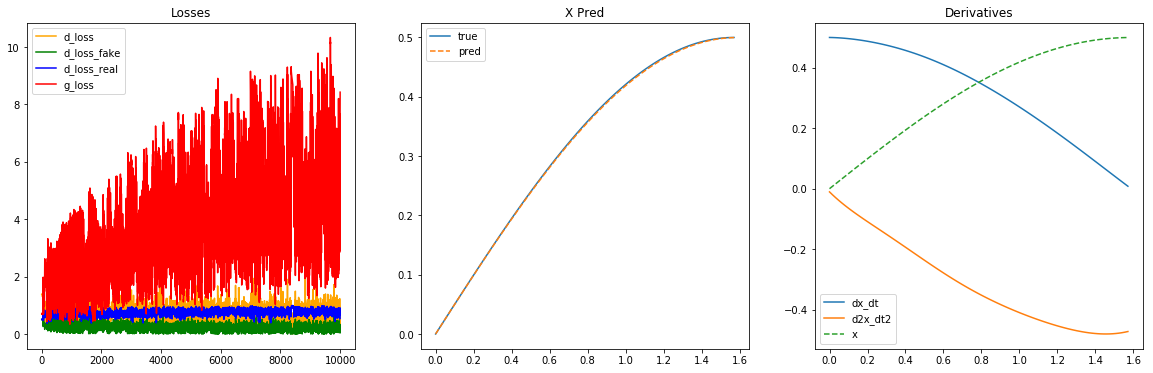

CPU times: user 4min 23s, sys: 45.6 s, total: 5min 8s
Wall time: 4min 26s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Here we are using vector input!

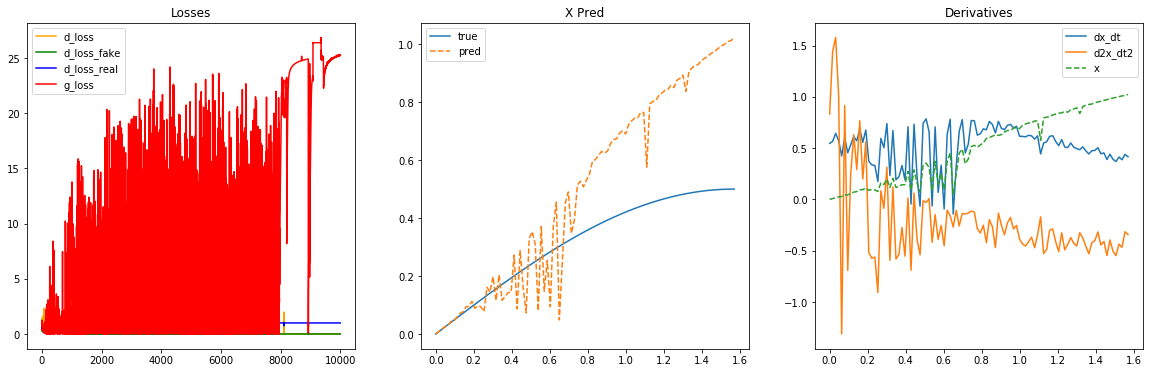

In [0]:
# %%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

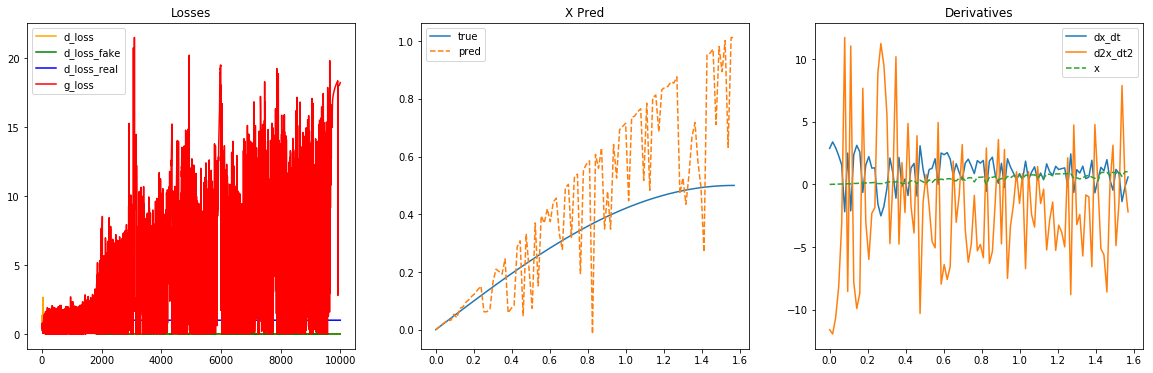

In [0]:
# %%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=100, 
                                  g_hidden_layers=1,
                                  d_hidden_units=100, 
                                  d_hidden_layers=1,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=4,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

## Using Conditional GAN

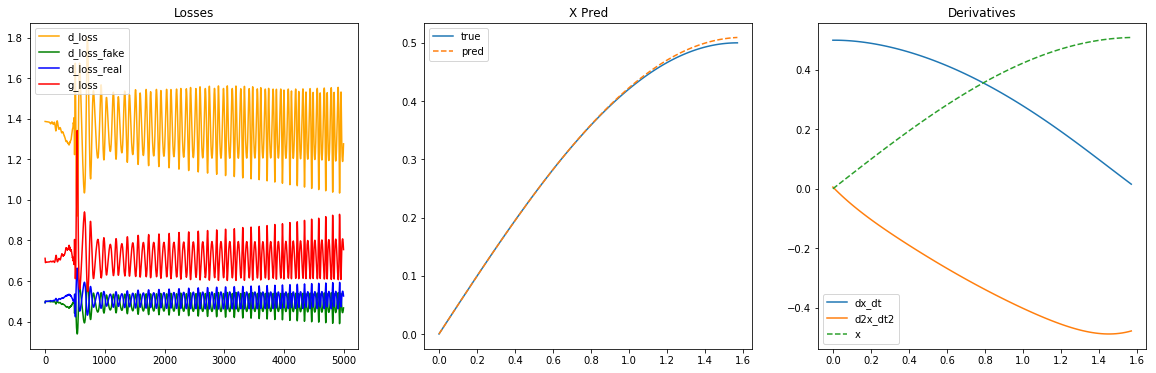

CPU times: user 2min 2s, sys: 20.5 s, total: 2min 22s
Wall time: 2min 4s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  5000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.0001,
                                  g_lr=0.0001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

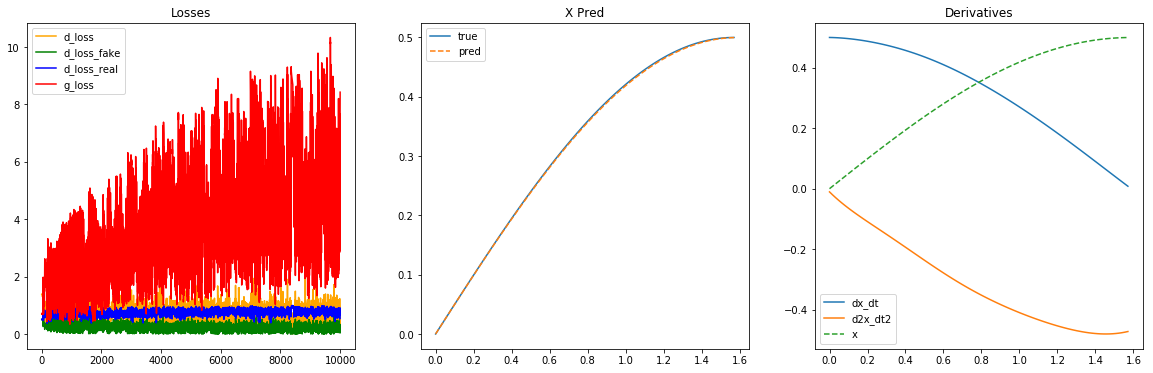

CPU times: user 4min 9s, sys: 45 s, total: 4min 54s
Wall time: 4min 11s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

## LSTM

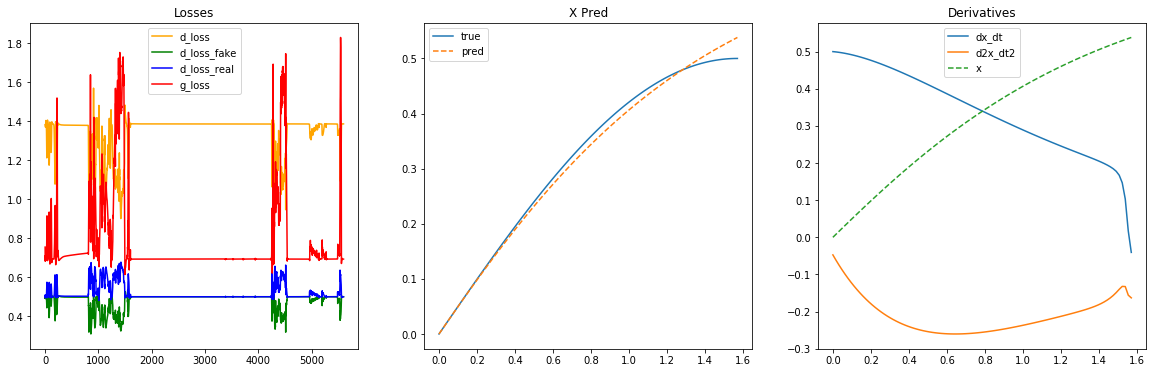

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Data

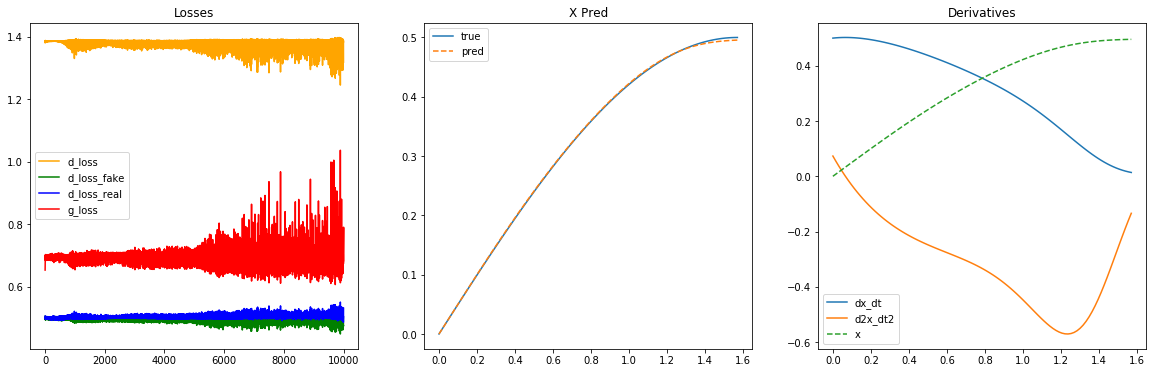

CPU times: user 3min 30s, sys: 42.4 s, total: 4min 12s
Wall time: 3min 31s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Fitting on $(0, .6 \pi)$

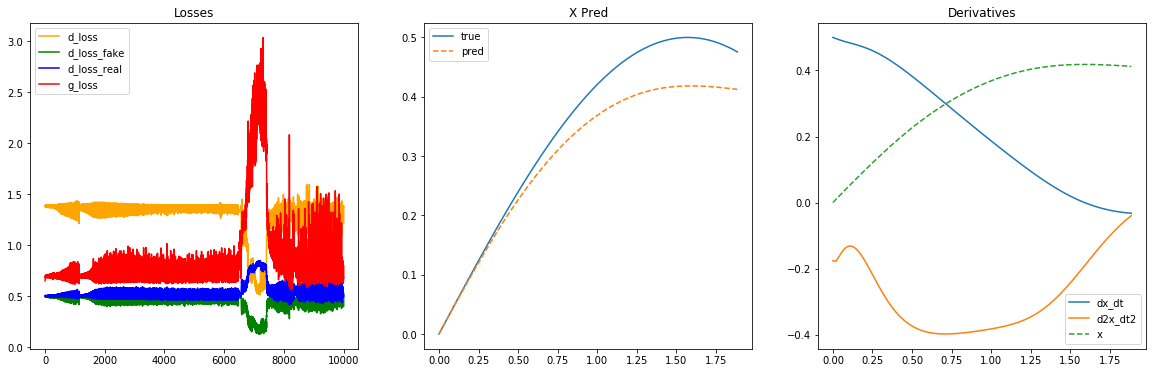

CPU times: user 4min 28s, sys: 45.9 s, total: 5min 14s
Wall time: 4min 32s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

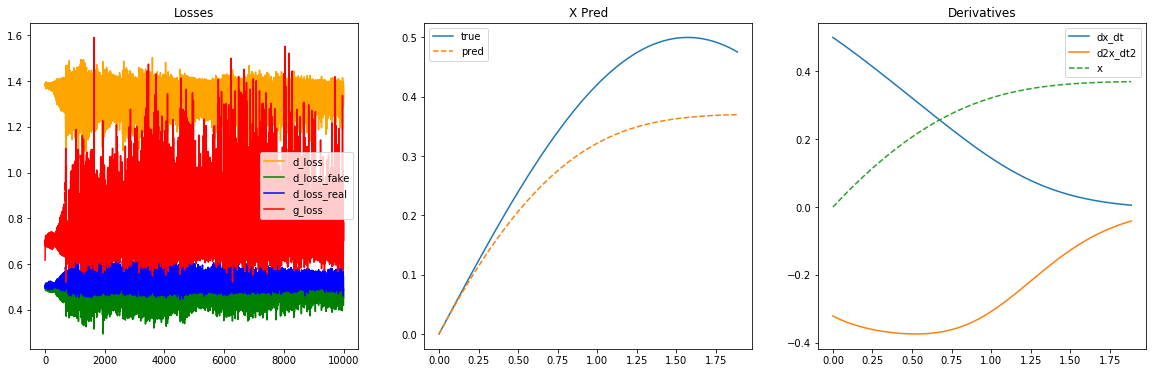

CPU times: user 4min 41s, sys: 48.2 s, total: 5min 29s
Wall time: 4min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

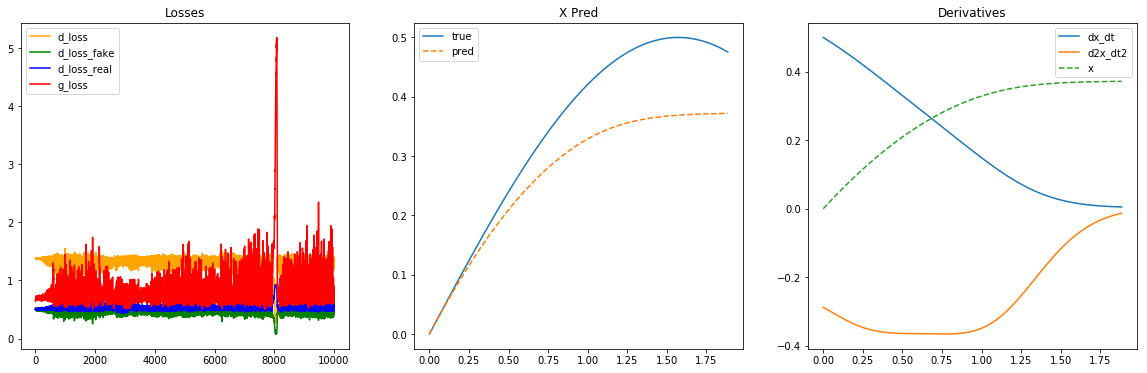

CPU times: user 4min 38s, sys: 47 s, total: 5min 25s
Wall time: 4min 42s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=40, # more node
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

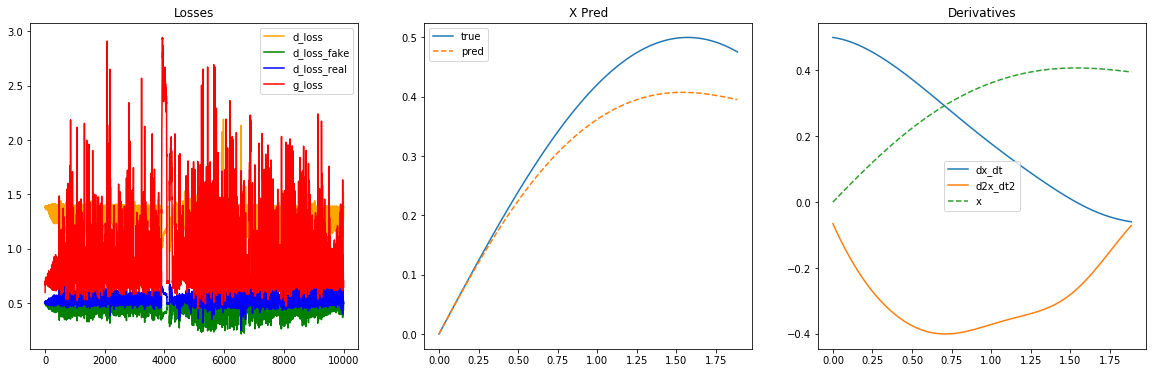

CPU times: user 4min 48s, sys: 46.1 s, total: 5min 34s
Wall time: 4min 53s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

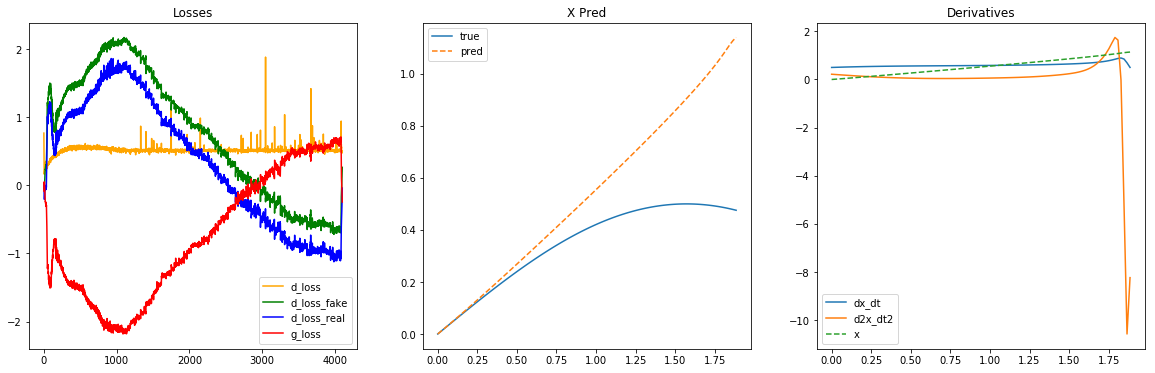

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=True,     # using WGAN
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

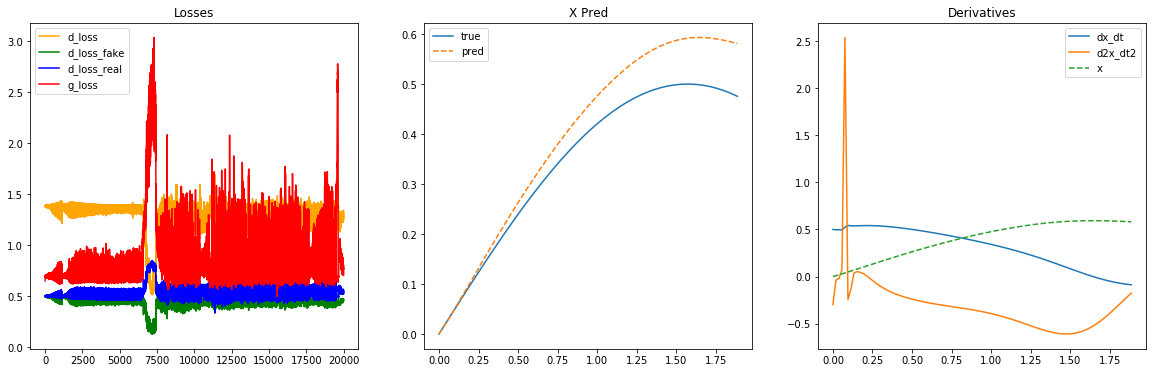

CPU times: user 9min 7s, sys: 1min 35s, total: 10min 42s
Wall time: 9min 13s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  20000,  # more eps

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

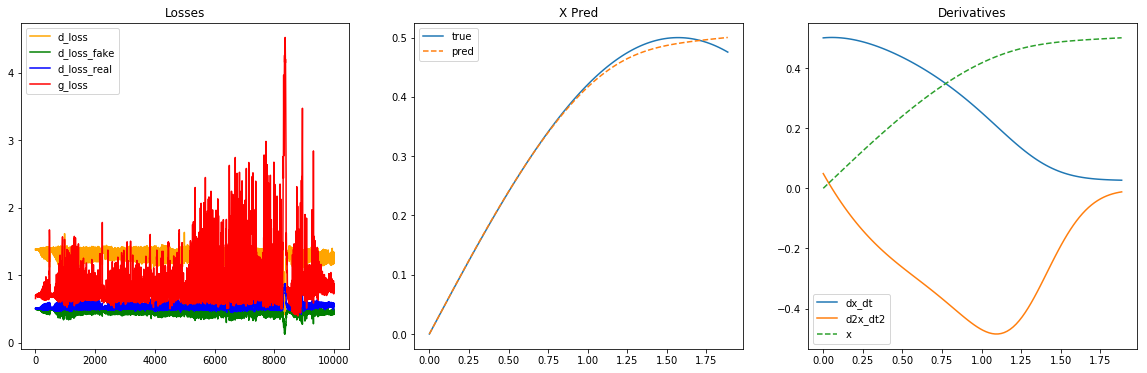

CPU times: user 6min 25s, sys: 51.7 s, total: 7min 17s
Wall time: 6min 36s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=9, # more D iters
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

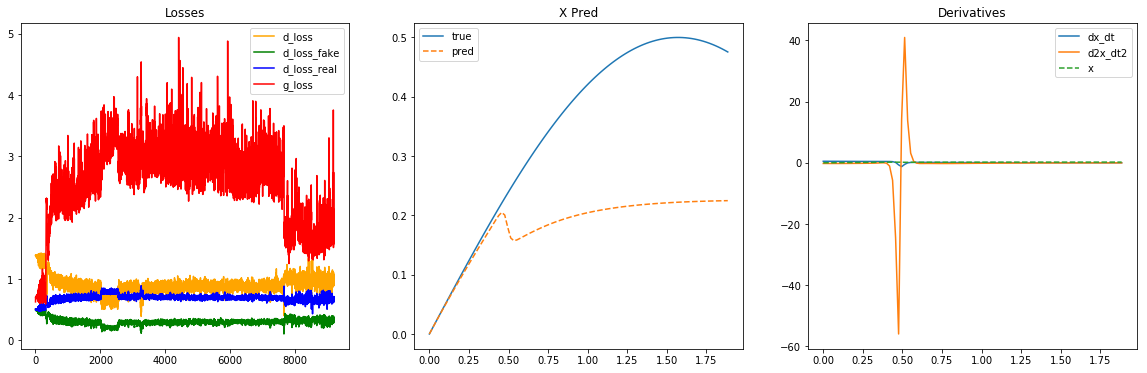

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=3, # more D layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=9, # more D iters
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

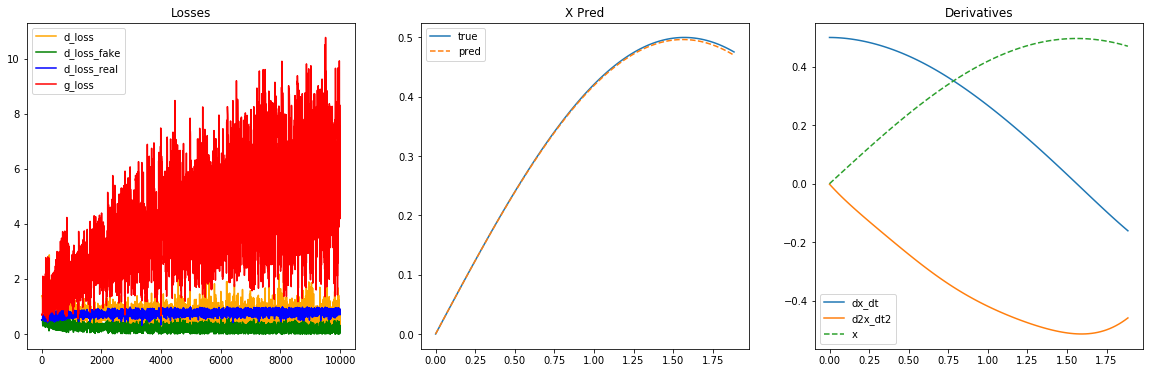

CPU times: user 4min 25s, sys: 44.8 s, total: 5min 10s
Wall time: 4min 28s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Check preds outside?

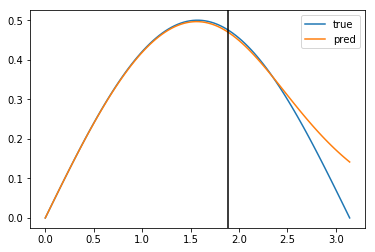

In [0]:
t_outside = torch.linspace(0, np.pi, 100, dtype=torch.float, requires_grad=True).reshape(-1,1)
# preds_outside = G(t_outside)
x0 = 0
dx_dt0 = .5
def produce_SHO_preds(G, t):
#         transpose for vector input
#         t = torch.t(t)

        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)
        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2
x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t_outside)
analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)
analytic_soln = analytic_oscillator_np(t_outside.detach().numpy())
plt.plot(t_outside.detach().numpy(), analytic_soln, label='true')
plt.plot(t_outside.detach().numpy(), x_adj.detach().numpy(), label='pred')
plt.axvline(0.6*np.pi, color='k')
plt.legend();

## Fitting on $(0, \pi)$

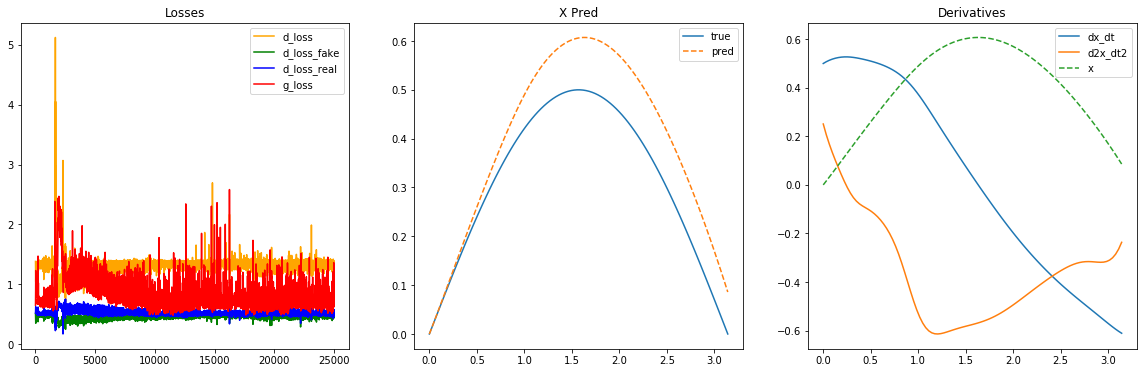

CPU times: user 10min 32s, sys: 1min 52s, total: 12min 24s
Wall time: 10min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

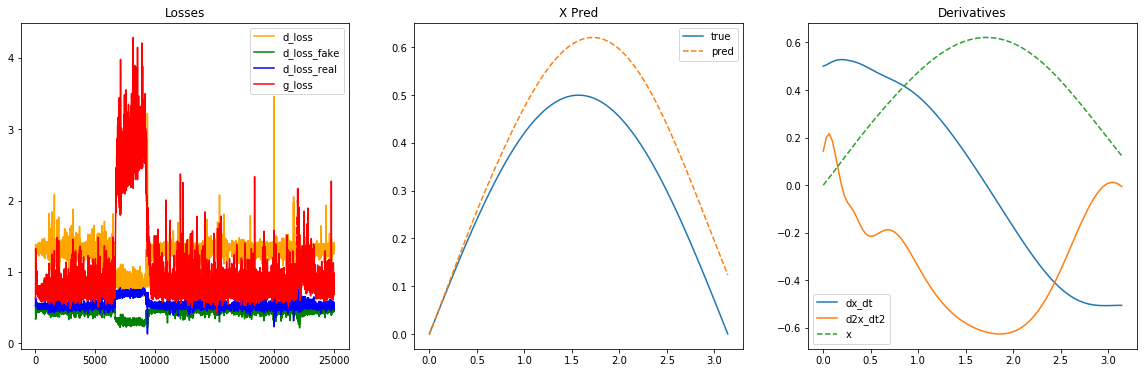

CPU times: user 11min 8s, sys: 1min 54s, total: 13min 2s
Wall time: 11min 16s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

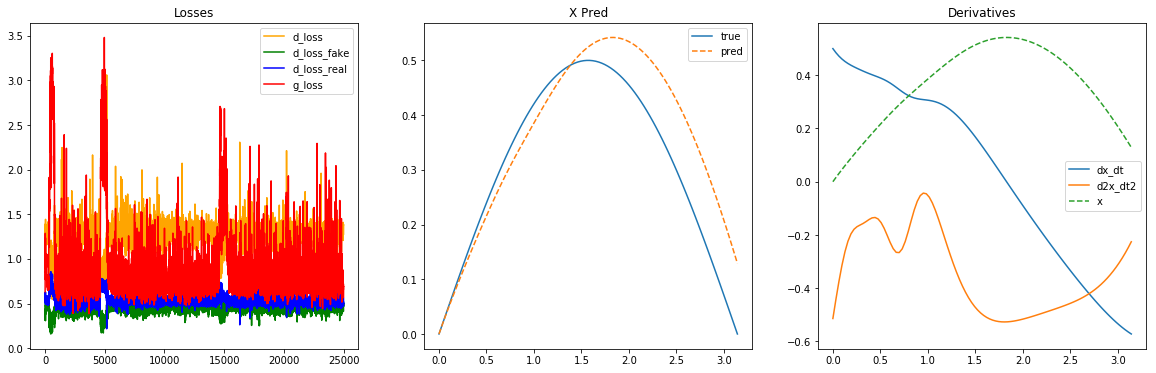

CPU times: user 11min 22s, sys: 1min 57s, total: 13min 19s
Wall time: 11min 29s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=20, 
                                  d_hidden_layers=3,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

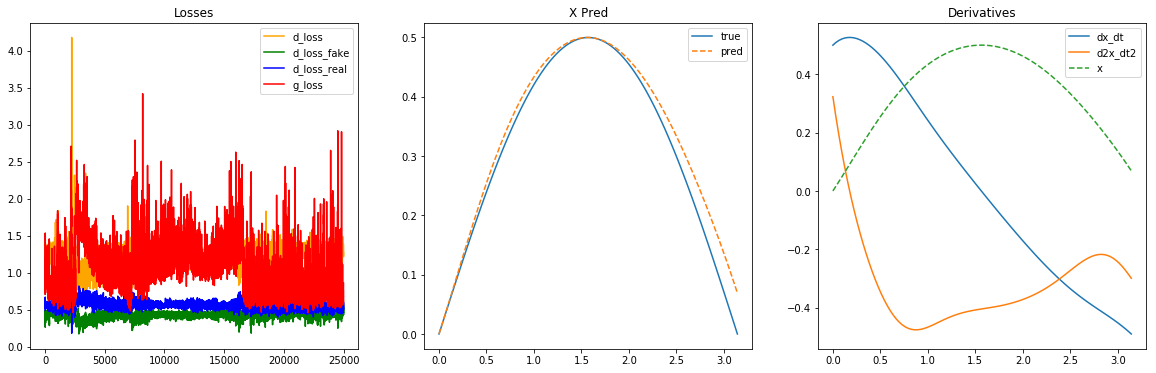

CPU times: user 11min 44s, sys: 2min, total: 13min 44s
Wall time: 11min 53s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

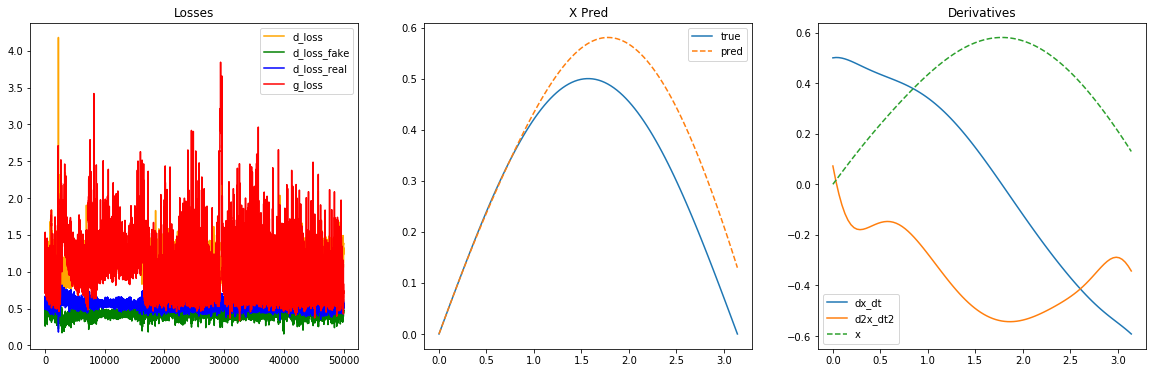

CPU times: user 24min 24s, sys: 4min 5s, total: 28min 29s
Wall time: 24min 37s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  50000,  # more epoch

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

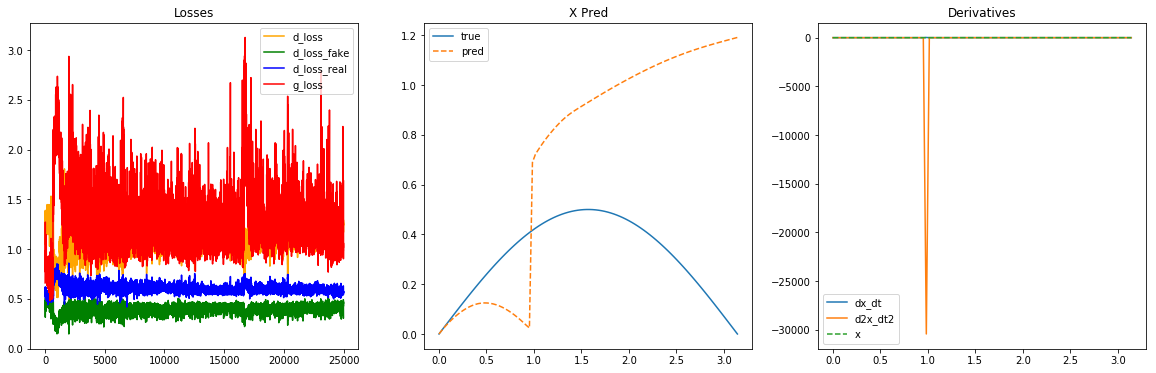

CPU times: user 12min 12s, sys: 2min 1s, total: 14min 14s
Wall time: 12min 21s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, # more node
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

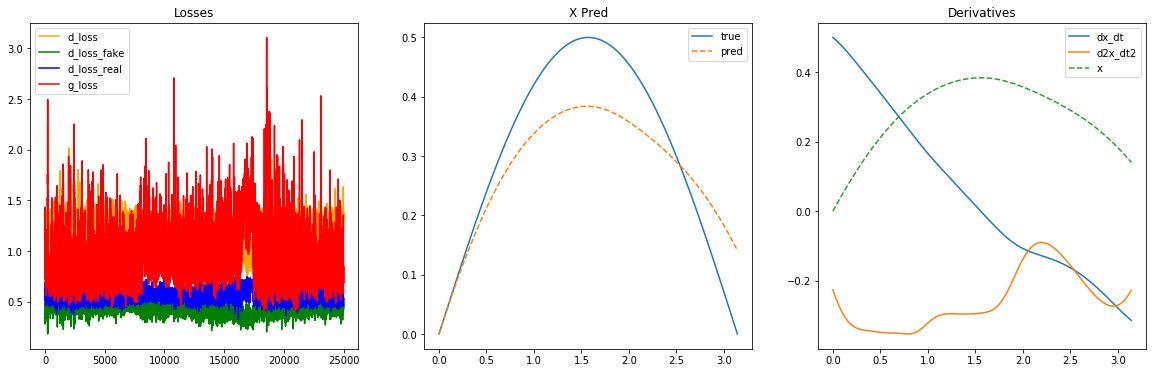

CPU times: user 12min 27s, sys: 2min 2s, total: 14min 30s
Wall time: 12min 36s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=40, # more node
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

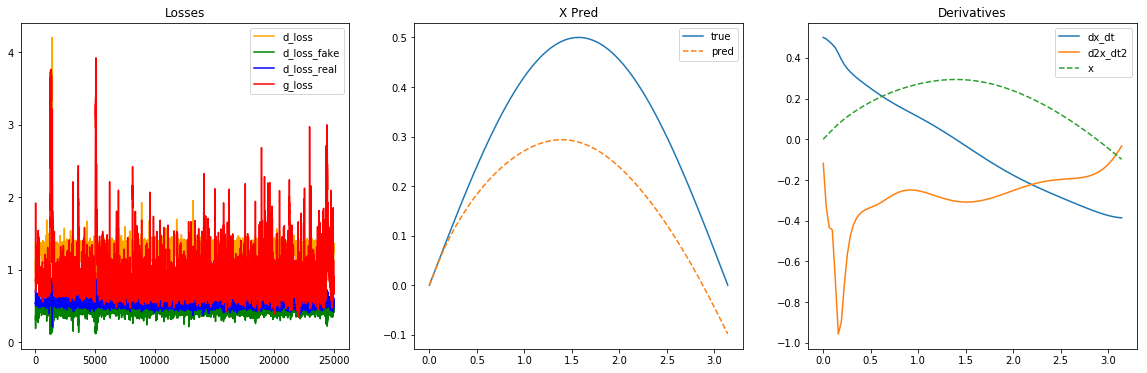

CPU times: user 12min 3s, sys: 1min 58s, total: 14min 2s
Wall time: 12min 12s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=40, # more node on D
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

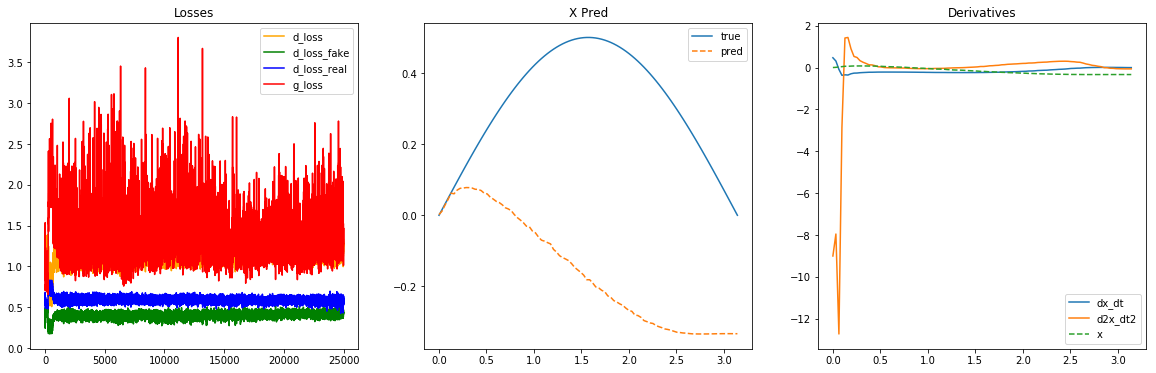

CPU times: user 12min 2s, sys: 2min 2s, total: 14min 4s
Wall time: 12min 11s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=True)

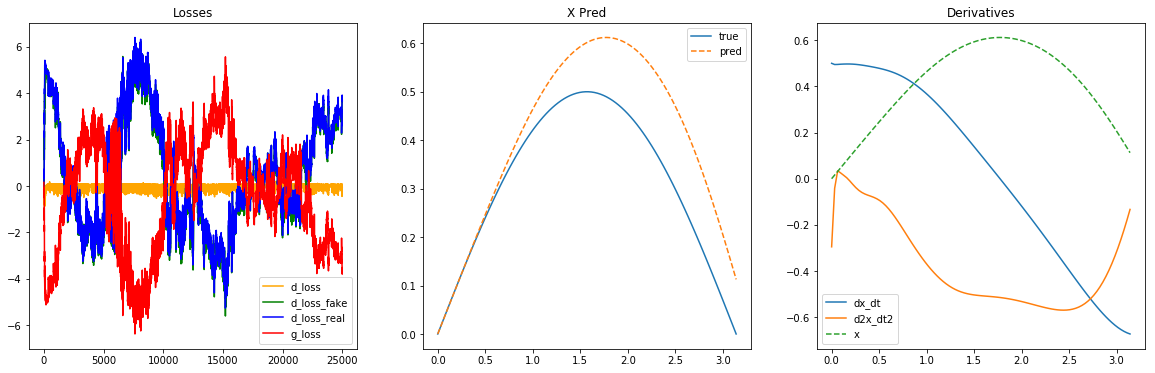

CPU times: user 32min 15s, sys: 2min 40s, total: 34min 56s
Wall time: 33min 10s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=True,
                                  gradient_penalty=True,
                                  gp_hyper=.1,

                                  # SYSTEM
                                  systemOfODE=False)

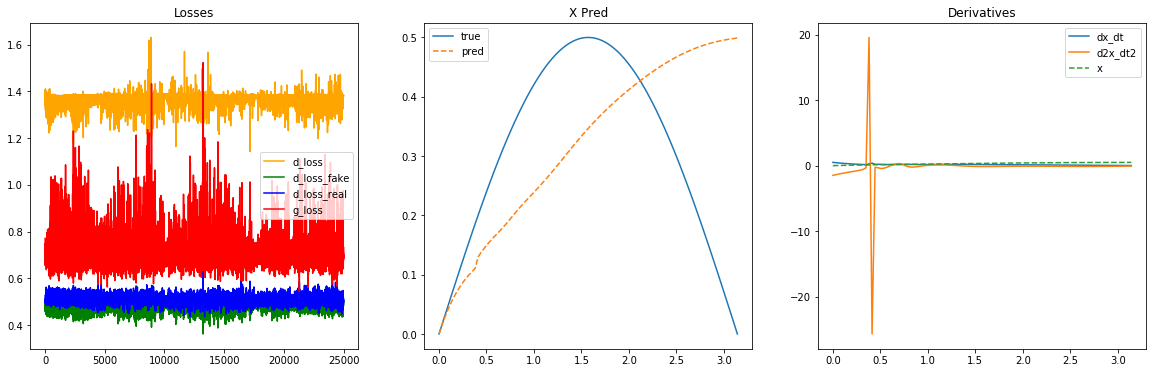

CPU times: user 9min 57s, sys: 1min 58s, total: 11min 56s
Wall time: 9min 59s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,  # use real                                    
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

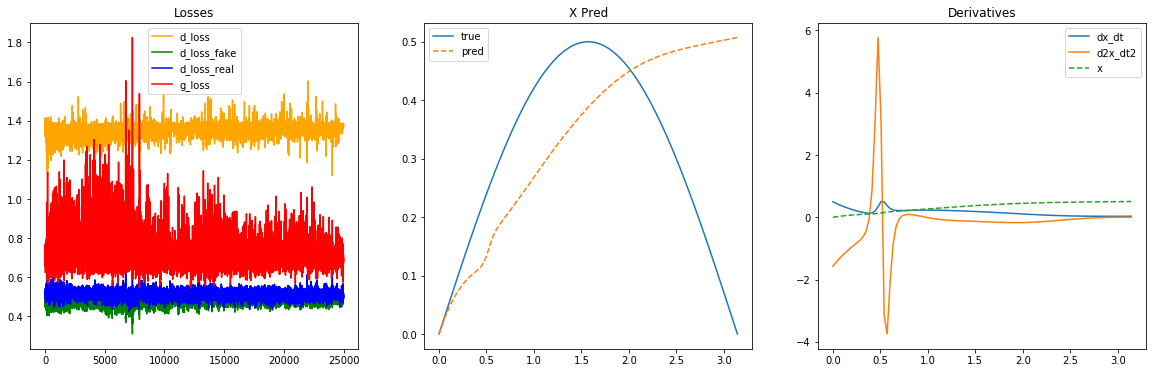

CPU times: user 10min 9s, sys: 1min 57s, total: 12min 7s
Wall time: 10min 14s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=4, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,  # use real                                    
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

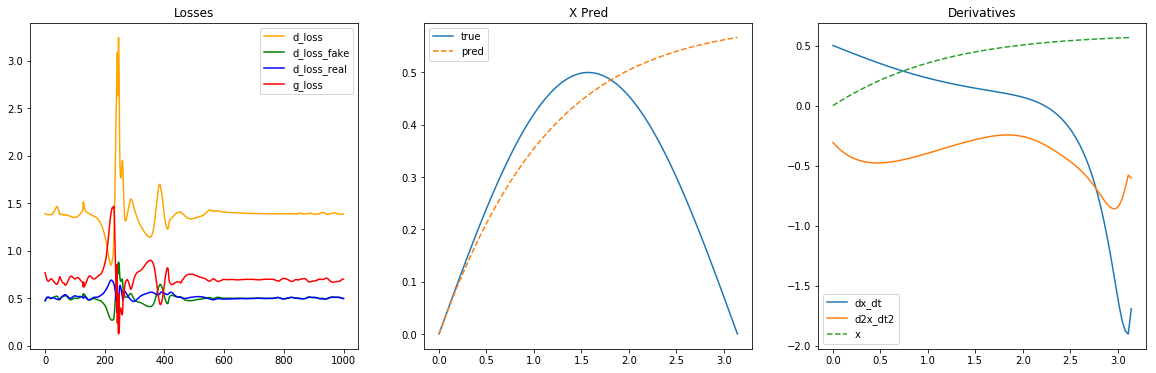

KeyboardInterrupt: ignored

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

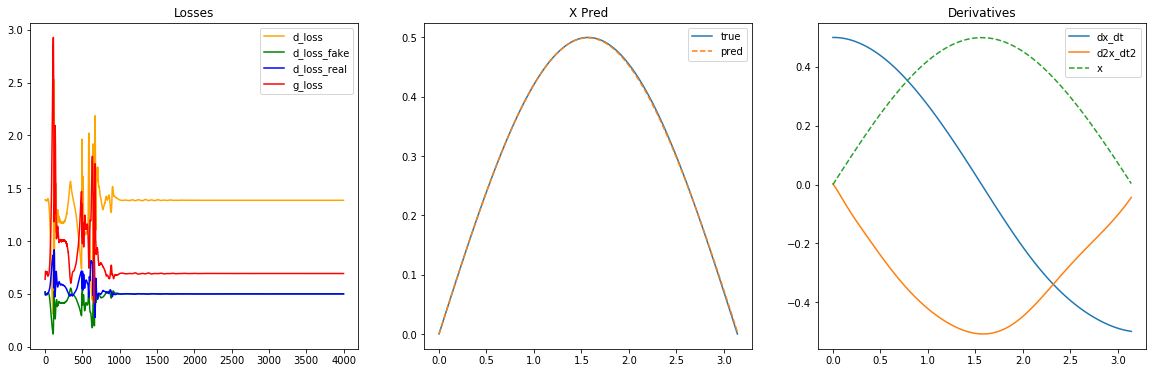

CPU times: user 59.1 s, sys: 13.7 s, total: 1min 12s
Wall time: 58.5 s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  4000, # less eps

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Fitting on $(0,2\pi)$

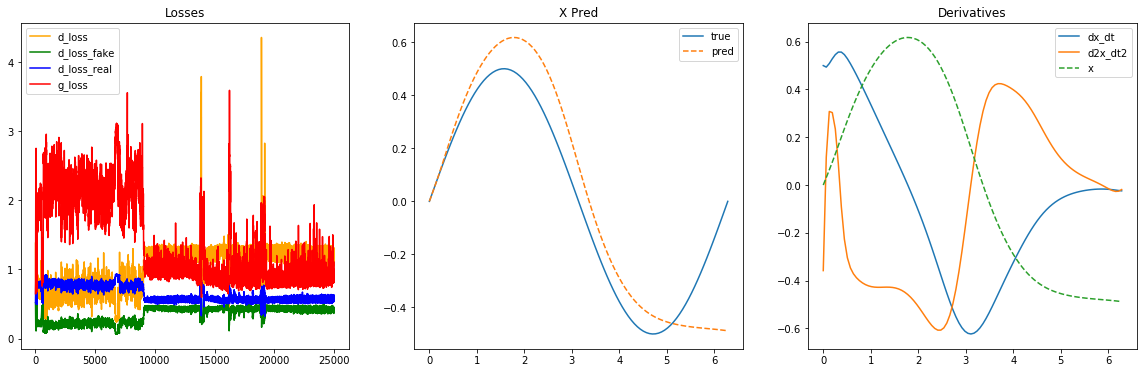

CPU times: user 10min 51s, sys: 2min, total: 12min 51s
Wall time: 10min 57s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

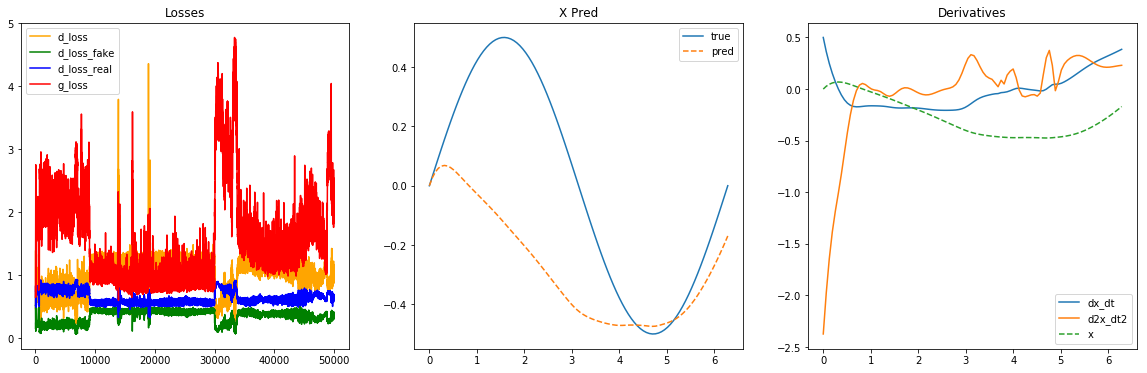

CPU times: user 21min 59s, sys: 4min 2s, total: 26min 2s
Wall time: 22min 10s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  50000,    # more epochs

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

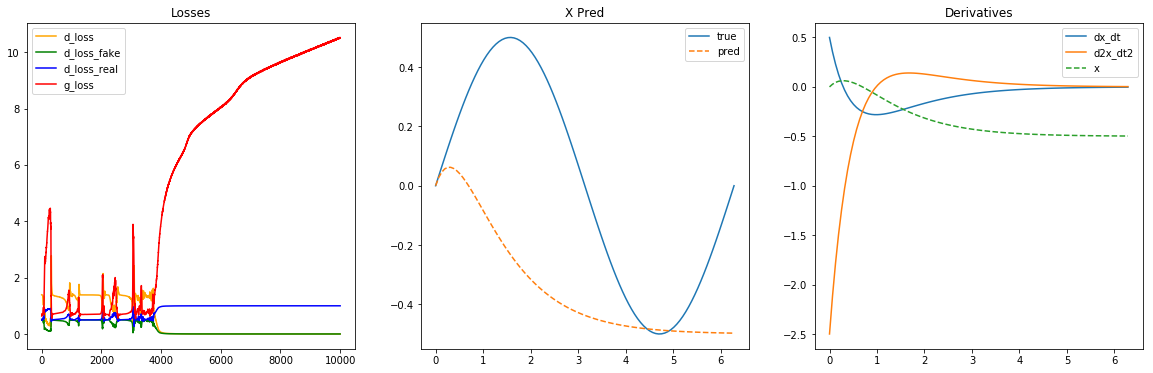

CPU times: user 2min 30s, sys: 34.7 s, total: 3min 5s
Wall time: 2min 28s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

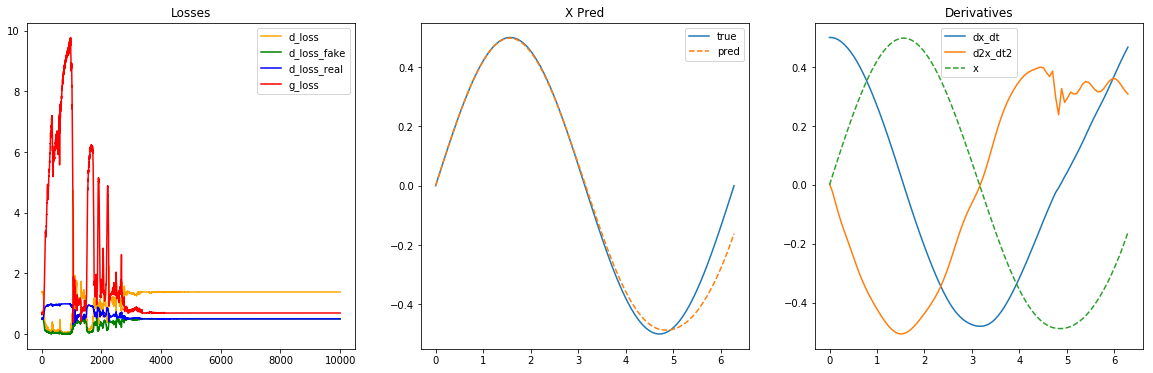

CPU times: user 4min 36s, sys: 42.1 s, total: 5min 19s
Wall time: 4min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

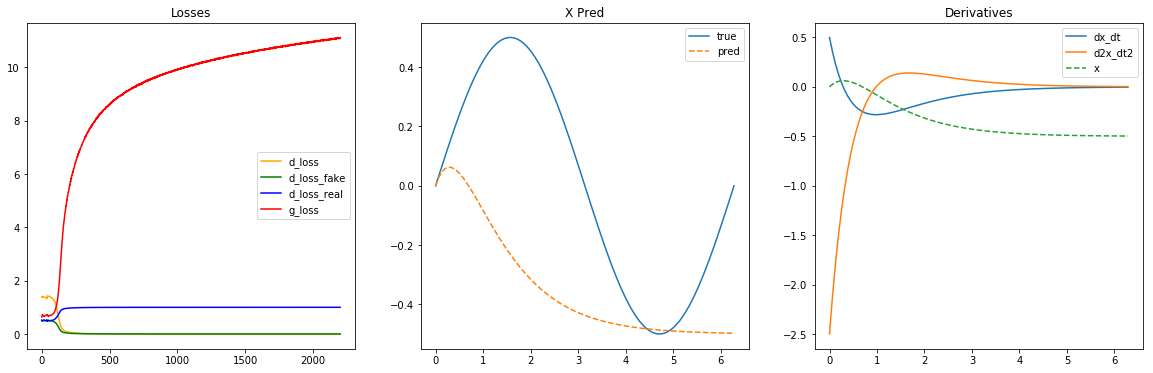

KeyboardInterrupt: ignored

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=9,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

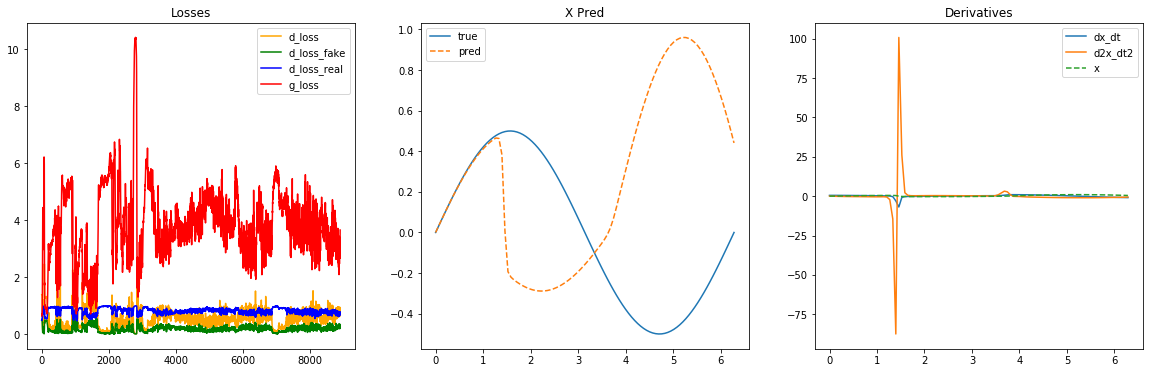

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=4,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

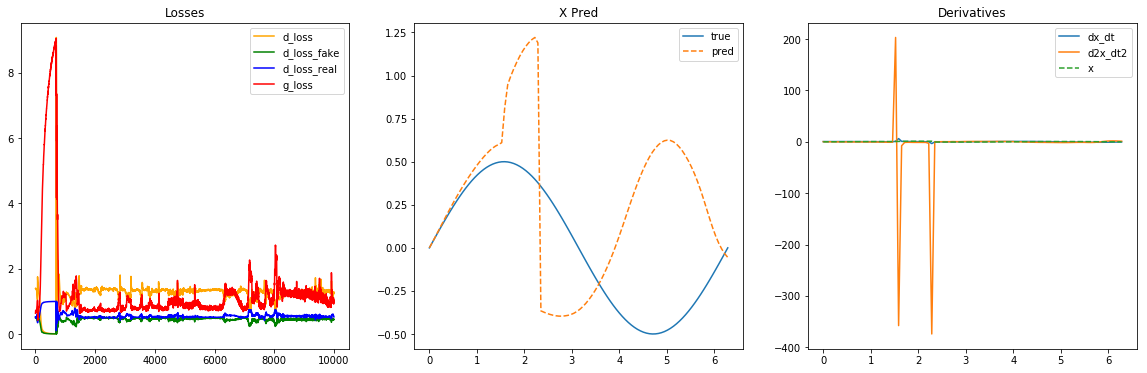

CPU times: user 4min 20s, sys: 40.5 s, total: 5min 1s
Wall time: 4min 26s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

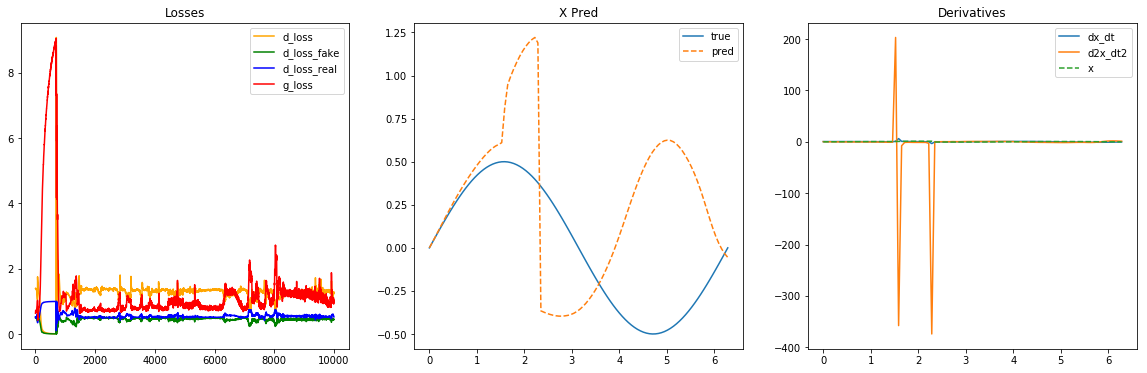

CPU times: user 4min 21s, sys: 41.1 s, total: 5min 2s
Wall time: 4min 27s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

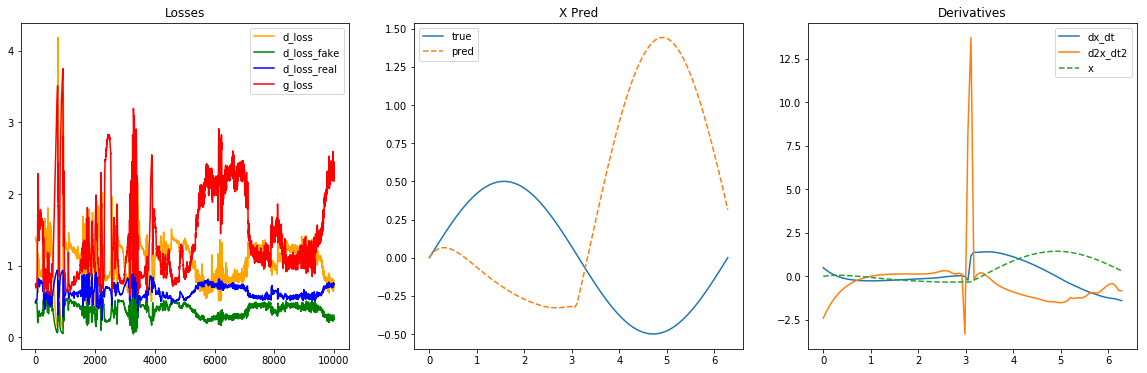

CPU times: user 2min 34s, sys: 34.7 s, total: 3min 8s
Wall time: 2min 32s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, 
                                  g_hidden_layers=3,
                                  d_hidden_units=40, 
                                  d_hidden_layers=3,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=1,
                                  d_lr=0.0005,
                                  g_lr=0.0005,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

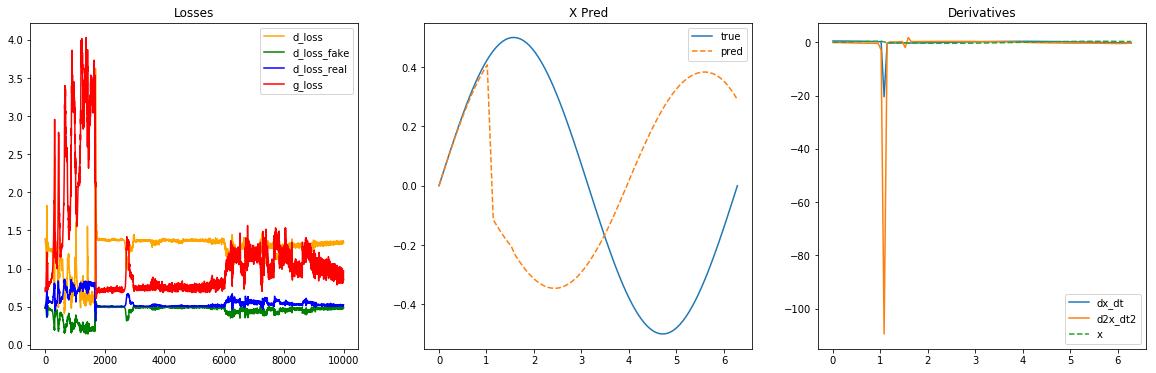

CPU times: user 4min 28s, sys: 43.7 s, total: 5min 12s
Wall time: 4min 34s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, 
                                  g_hidden_layers=3,
                                  d_hidden_units=40, 
                                  d_hidden_layers=3,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.0005,
                                  g_lr=0.0005,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

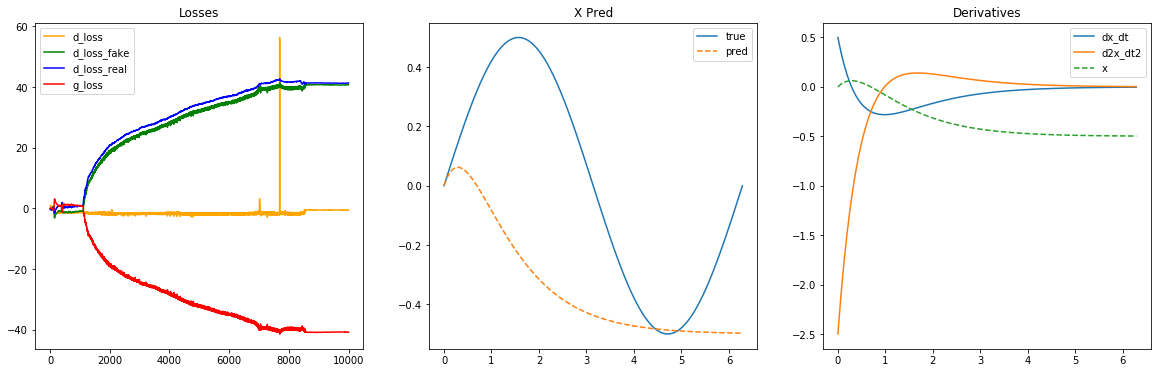

CPU times: user 6min 24s, sys: 47.2 s, total: 7min 11s
Wall time: 6min 34s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, 
                                  g_hidden_layers=3,
                                  d_hidden_units=40, 
                                  d_hidden_layers=3,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.0005,
                                  g_lr=0.0005,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=True,
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)